## Importing Major Libraries

In [42]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.signal import welch, find_peaks
import warnings as wr
wr.filterwarnings('ignore')

## Importing the Dataset

In [44]:
# Importing the CSV file
df = pd.read_csv('B1_CL4_20.csv',low_memory=False)

## Frequency Domain Analysis

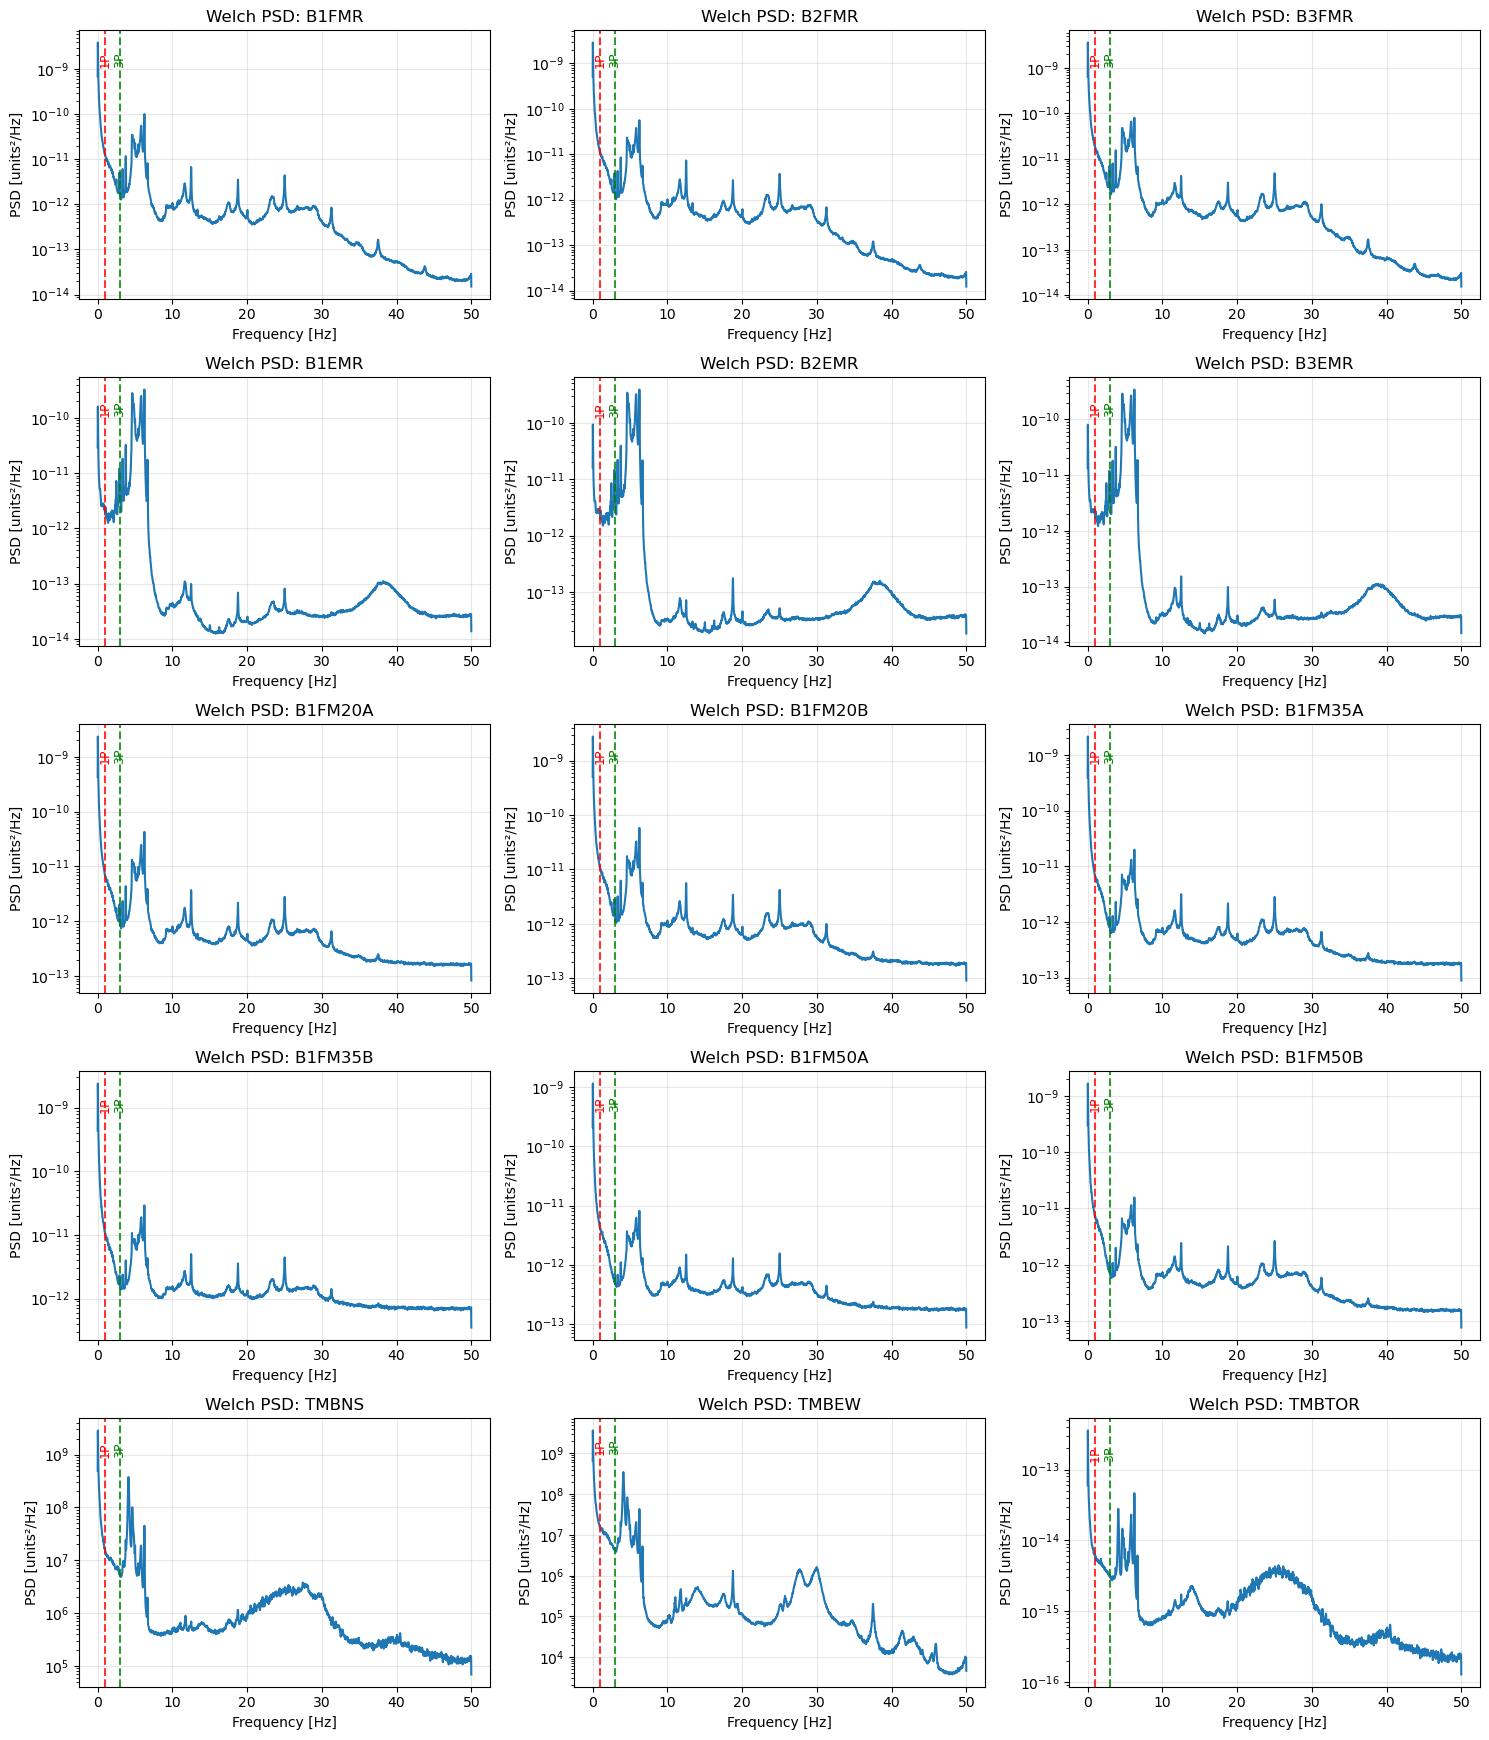

In [46]:
def estimate_1P_from_rpm(df, rpm_cols=("XTurbSpeed1","TurbSpeed2","RPM","RotorSpeedRPM")):
    """Estimate 1P [Hz] from an RPM column if present; else return None."""
    for c in rpm_cols:
        if c in df.columns:
            rpm = pd.to_numeric(df[c], errors="coerce").dropna()
            if len(rpm) > 0:
                rpm_med = np.median(rpm)
                return float(rpm_med / 60.0)  # Hz
    return None

def estimate_1P_from_psd(signal, fs, f_max=5.0):
    """Fallback: infer 1P as dominant low-frequency peak below f_max."""
    f, Pxx = welch(signal, fs=fs, nperseg=min(4096, max(256, len(signal)//4)))
    mask = (f > 0.1) & (f < f_max)
    if not np.any(mask):
        return None
    idx = np.argmax(Pxx[mask])
    return float(f[mask][idx])

def band_energy(f, Pxx, f0, bw=0.2):
    """Integrate PSD in a band centered on f0 with +/- bw [Hz]."""
    m = (f >= max(0, f0 - bw)) & (f <= f0 + bw)
    return float(np.trapz(Pxx[m], f[m])) if np.any(m) else np.nan

def classify_peak(freq, f1P, tol=0.15):
    """Label a peak by proximity to 1P/3P or by mode bands."""
    if f1P is not None:
        if abs(freq - f1P) <= tol * f1P:
            return "1P"
        if abs(freq - 3*f1P) <= tol * 3 * f1P:
            return "3P"
    # heuristic bands for modes (tune for your turbine)
    if 0.5 <= freq <= 3.0:
        return "tower/low-mode"
    if 2.0 <= freq <= 6.0:
        return "first-flap"
    if 8.0 <= freq <= 20.0:
        return "edgewise/higher"
    return "other"


# Core analysis

def analyze_psd_all(
    df,
    channels,
    fs=100,
    rpm_cols=("XTurbSpeed1","TurbSpeed2","RPM","RotorSpeedRPM"),
    nperseg=None,
    plot=True,
    max_plots_per_row=3,
    prominence=1e-14,
    distance_hz=0.3
):
    """
    For each channel in `channels`:
      - compute Welch PSD
      - estimate 1P (from RPM if present, else from PSD)
      - detect peaks and classify them as 1P/3P or likely modes
      - optionally plot PSD with 1P/3P markers
    Returns:
      psd_dict: {channel: (f, Pxx)}
      peaks_df: long-form table of detected peaks with labels and band energies
    """
    # 1P from RPM if available
    f1P_global = estimate_1P_from_rpm(df, rpm_cols=rpm_cols)

    psd_dict = {}
    rows = []

    if nperseg is None:
        # reasonable default
        nperseg = min(4096, max(256, len(df)//8))

    # convert distance in Hz to bins after we know f grid (later)
    dist_bins_cache = {}

    for ch in channels:
        x = pd.to_numeric(df[ch], errors="coerce").dropna().to_numpy()
        if x.size < 256:
            continue
        f, Pxx = welch(x, fs=fs, nperseg=nperseg)
        psd_dict[ch] = (f, Pxx)

        # estimate 1P if we didn't get it from RPM
        f1P = f1P_global if f1P_global is not None else estimate_1P_from_psd(x, fs)

        # peak picking
        if ch not in dist_bins_cache:
            dfreq = np.median(np.diff(f))
            dist_bins_cache[ch] = max(1, int(round(distance_hz / max(dfreq, 1e-9))))
        distance_bins = dist_bins_cache[ch]

        idx, props = find_peaks(Pxx, prominence=prominence, distance=distance_bins)
        peak_freqs = f[idx]
        peak_powers = Pxx[idx]

        # keep only meaningful range
        keep = (peak_freqs > 0.1) & (peak_freqs < fs/2 - 0.5)
        peak_freqs, peak_powers = peak_freqs[keep], peak_powers[keep]

        # band energies around (estimated) 1P and 3P
        E_1P = band_energy(f, Pxx, f1P, bw=0.2) if f1P is not None else np.nan
        E_3P = band_energy(f, Pxx, 3*f1P, bw=0.2) if f1P is not None else np.nan

        for fr, pw in zip(peak_freqs, peak_powers):
            label = classify_peak(fr, f1P)
            rows.append({
                "channel": ch,
                "f_peak_hz": float(fr),
                "psd_peak": float(pw),
                "label": label,
                "f1P_est": float(f1P) if f1P is not None else np.nan,
                "E_1P_band": E_1P,
                "E_3P_band": E_3P
            })

    peaks_df = pd.DataFrame(rows).sort_values(["channel","f_peak_hz"]).reset_index(drop=True)

    
    # Plotting
   
    if plot and psd_dict:
        n = len(psd_dict)
        ncols = min(max_plots_per_row, n)
        nrows = int(np.ceil(n / ncols))
        fig, axes = plt.subplots(nrows, ncols, figsize=(5*ncols, 3.5*nrows), squeeze=False)

        # Use same global 1P if available, else per-channel estimates
        for ax, (ch, (f, Pxx)) in zip(axes.ravel(), psd_dict.items()):
            ax.semilogy(f, Pxx)
            ax.set_title(f"Welch PSD: {ch}")
            ax.set_xlabel("Frequency [Hz]")
            ax.set_ylabel("PSD [units²/Hz]")
            ax.grid(True, alpha=0.3)

            # 1P/3P markers (prefer global RPM-based if available; else per-channel)
            f1P = f1P_global
            if f1P is None:
                # pull per-channel estimate from peaks_df
                f1P_vals = peaks_df.loc[peaks_df["channel"]==ch, "f1P_est"].dropna()
                f1P = float(f1P_vals.iloc[0]) if len(f1P_vals)>0 else None

            if f1P is not None and f1P > 0:
                for mult, color, label in [(1,"r","1P"), (3,"g","3P")]:
                    fm = mult * f1P
                    if fm < (f[-1] - 0.5):
                        ax.axvline(fm, linestyle="--", alpha=0.8, color=color)
                        ax.text(fm, np.max(Pxx)*0.6, label, rotation=90,
                                va="top", ha="center", color=color, fontsize=9)

        # clean extra axes if any
        for k in range(len(psd_dict), nrows*ncols):
            axes.ravel()[k].axis("off")
        plt.tight_layout()

    return psd_dict, peaks_df


# Example usage
if __name__ == "__main__":
    # Choose blade root channels (flap/edge)
    channels = ["B1FMR","B2FMR","B3FMR","B1EMR","B2EMR","B3EMR",'B1FM20A', 'B1FM20B', 'B1FM35A', 'B1FM35B', 'B1FM50A','B1FM50B','TMBNS', 'TMBEW', 'TMBTOR']
    psd_dict, peaks = analyze_psd_all(df, channels, fs=100, rpm_cols=("XTurbSpeed1","TurbSpeed2"))
    pass


## Coherence Analysis Between Blades- Flapwise Moments

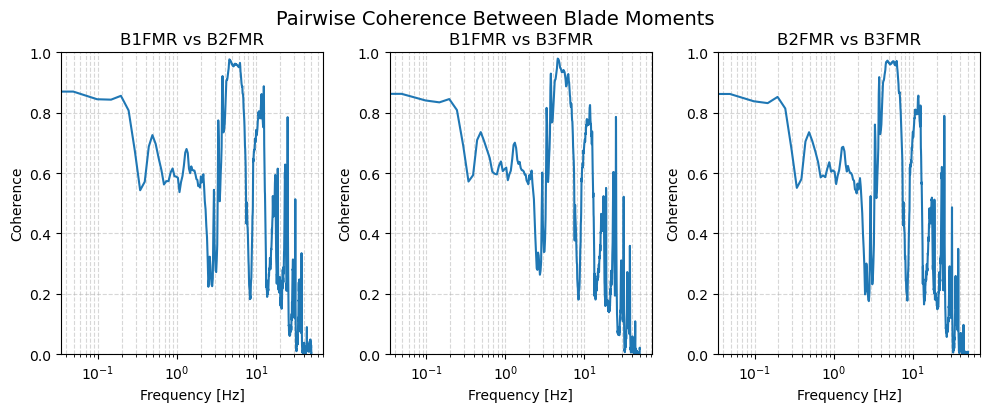

In [48]:
import itertools
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import coherence

# -------------------------
# CONFIGURATION
# -------------------------
fs = 100  # Sampling frequency in Hz (edit based on your dataset)
moment_cols = ['B1FMR', 'B2FMR', 'B3FMR']  # moment signals
window = 'hann'
nperseg = 2048

# -------------------------
# PAIRWISE COHERENCE PLOTS
# -------------------------
pairs = list(itertools.combinations(moment_cols, 2))

fig, axes = plt.subplots(
    nrows=len(pairs)//3 + (len(pairs) % 3 > 0), 
    ncols=3, 
    figsize=(10, 4)
)
axes = axes.ravel()

for i, (col1, col2) in enumerate(pairs):
    # Compute coherence
    f, Cxy = coherence(
        df[col1].dropna(), 
        df[col2].dropna(), 
        fs=fs, 
        nperseg=nperseg, 
        window=window
    )

    # Plot
    axes[i].semilogx(f, Cxy)
    axes[i].set_title(f"{col1} vs {col2}")
    axes[i].set_xlabel("Frequency [Hz]")
    axes[i].set_ylabel("Coherence")
    axes[i].set_ylim(0, 1)
    axes[i].grid(True, which='both', ls='--', alpha=0.5)

# Hide any unused subplots
for j in range(i+1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.suptitle("Pairwise Coherence Between Blade Moments", fontsize=14, y=1.02)
plt.show()


## Coherence Analysis Between Blades- Flapwise Moments

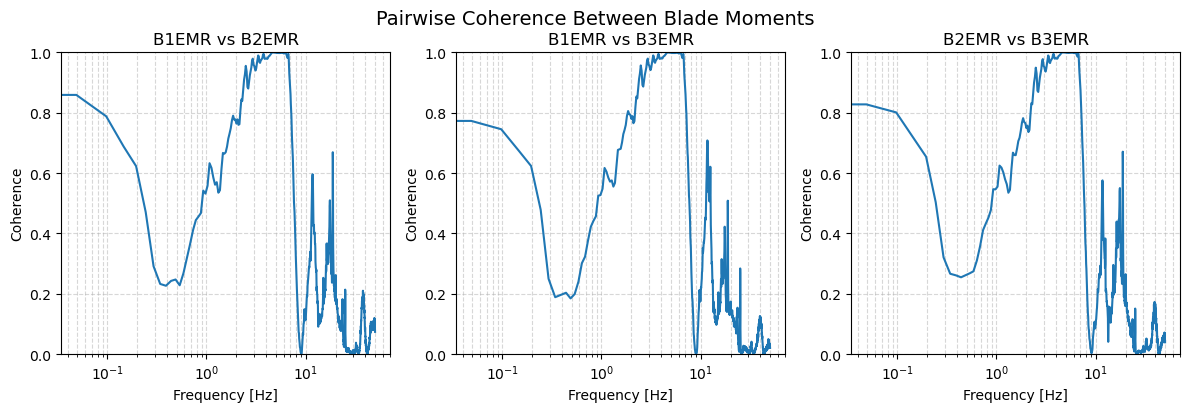

In [50]:
import itertools
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import coherence

# -------------------------
# CONFIGURATION
# -------------------------
fs = 100  # Sampling frequency in Hz (edit based on your dataset)
moment_cols = ['B1EMR', 'B2EMR', 'B3EMR']  # moment signals
window = 'hann'
nperseg = 2048

# -------------------------
# PAIRWISE COHERENCE PLOTS
# -------------------------
pairs = list(itertools.combinations(moment_cols, 2))

fig, axes = plt.subplots(
    nrows=len(pairs)//3 + (len(pairs) % 3 > 0), 
    ncols=3, 
    figsize=(12, 4)
)
axes = axes.ravel()

for i, (col1, col2) in enumerate(pairs):
    # Compute coherence
    f, Cxy = coherence(
        df[col1].dropna(), 
        df[col2].dropna(), 
        fs=fs, 
        nperseg=nperseg, 
        window=window
    )

    # Plot
    axes[i].semilogx(f, Cxy)
    axes[i].set_title(f"{col1} vs {col2}")
    axes[i].set_xlabel("Frequency [Hz]")
    axes[i].set_ylabel("Coherence")
    axes[i].set_ylim(0, 1)
    axes[i].grid(True, which='both', ls='--', alpha=0.5)

# Hide any unused subplots
for j in range(i+1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.suptitle("Pairwise Coherence Between Blade Moments", fontsize=14, y=1.02)
plt.show()


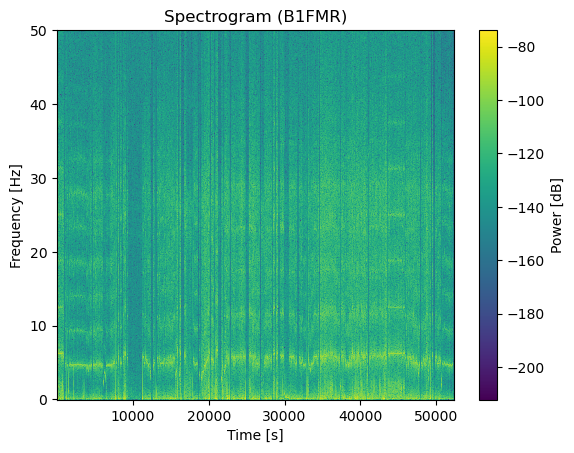

In [51]:
from scipy.signal import spectrogram
f, t, Sxx = spectrogram(df['B1FMR'], fs=100, nperseg=1024)
plt.pcolormesh(t, f, 10*np.log10(Sxx))
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [s]')
plt.title('Spectrogram (B1FMR)')
plt.colorbar(label='Power [dB]')